# **Loan Approval Prediction using Logistic Regression**

## **Problem Statement**

Assessing a borrower’s creditworthiness is a critical step in minimizing default risk for financial institutions. However, relying solely on predefined rules or traditional assessment methods may not yield the most accurate predictions. To enhance decision-making, this project employs Logistic Regression, a supervised machine learning algorithm designed for binary classification, to predict whether a borrower is capable of repaying a loan based on various financial and demographic factors.

In this study, we analyzed key variables such as age, income, credit history, outstanding loan balance, and employment status to estimate the likelihood of loan default so as to determine whether or not the loan to be approved. To improve accessibility and usability, the trained machine learning model is deployed within an interactive Streamlit [<u>application</u>](https://creditscoringprediction.streamlit.app/). Users can input relevant background and financial details of a borrower to instantly obtain both the default probability and repayment probability. Additionally, a waterfall chart visually explains which specific factors most strongly influenced the model’s prediction — providing transparency and interpretability. This data-driven approach enables financial institutions to make more informed, objective, and risk-aware lending decisions, ultimately supporting more efficient and equitable credit evaluation.

## **Workflow Summary**
A synthetic dataset is used to train a logistic regression model that predicts the likelihood of borrower default, which in turn determines loan approval decisions.

1. Import required libraries
2. Clean the data by removing the duplicates, checking for missing values and processing categorical variable
3. Split the dataset into training (70%) and test (30%) sets
4. Standardize the data between 0 and 1 using StandardScaler
5. Build logistic regression model with class balancing which is trained on the scaled training data
6. Evaluate the model with confusion matrix, PR-AUC score and ROC-AUC score
7. Save the model, scaler and SHAP explainer which are stored at [Github repository](https://github.com/cckmwong-data/credit_scoring) for [Streamlit application](https://creditscoringprediction.streamlit.app/) deployment

### **(1) Import Libaries**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install shap

### **(2) Exploratory Data Analysis and Data Preprocessing**
First, we clean the data by removing the duplicates, checking for missing values and processing categorical variable (Employment). The original Employment column is dropped, and the new dummy columns (Employed, Self-Employed, Unemployed) are converted from boolean values (True/False) into numeric form (1/0). This is followed by distribution plots of every attribute. Defaulter is represented as Repay_Loan = 0.

In [ ]:
# Read the credit scoring dataset
csv_path = 'https://raw.githubusercontent.com/cckmwong-data/credit_scoring/refs/heads/main/dataset/loan_data.csv'
df = pd.read_csv(csv_path)
df

,Client_ID,Age,Gender,Monthly_Income,Credit_History,Monthly_Repayment,Employment,Default_Flag
0,C00001,19,Male,3388.355000,6,1718.235833,Employed,1
1,C00002,43,Female,4520.793898,5,2767.346457,Unemployed,1
2,C00003,34,Male,3820.650000,6,1998.455833,Unemployed,0
3,C00004,48,Female,4319.538333,9,1571.132500,Unemployed,0
4,C00005,57,Female,3685.314167,1,1514.525833,Employed,0
...,...,...,...,...,...,...,...,...
2673,C02674,72,Female,4345.345833,1,2999.559167,Unemployed,1
2674,C02675,28,Male,5711.783333,8,1548.728333,Employed,0
2675,C02676,53,Male,5242.258333,8,1511.730000,Employed,0
2676,C02677,42,Female,3461.568333,1,1207.515000,Employed,0


In [ ]:
# since Client ID and gender are not a determining factor of the loan approval, we drop these columns
df = df.drop(['Gender'], axis = 1)
df = df.drop(['Client_ID'], axis = 1)

In [ ]:
# check any missing data
df.isnull().sum()

Age                  0
Monthly_Income       0
Credit_History       0
Monthly_Repayment    0
Employment           0
Default_Flag         0
dtype: int64

In [ ]:
# remove any duplicates
df = df.drop_duplicates()

In [ ]:
df['DTI'] = df['Monthly_Repayment']/ df['Monthly_Income']
df

,Age,Monthly_Income,Credit_History,Monthly_Repayment,Employment,Default_Flag,DTI
0,19,3388.355000,6,1718.235833,Employed,1,0.507100
1,43,4520.793898,5,2767.346457,Unemployed,1,0.612137
2,34,3820.650000,6,1998.455833,Unemployed,0,0.523067
3,48,4319.538333,9,1571.132500,Unemployed,0,0.363727
4,57,3685.314167,1,1514.525833,Employed,0,0.410962
...,...,...,...,...,...,...,...
2673,72,4345.345833,1,2999.559167,Unemployed,1,0.690292
2674,28,5711.783333,8,1548.728333,Employed,0,0.271146
2675,53,5242.258333,8,1511.730000,Employed,0,0.288374
2676,42,3461.568333,1,1207.515000,Employed,0,0.348835


In [ ]:
# Transform categorical variables
dummy = pd.get_dummies(df['Employment'])
data = pd.concat([df, dummy], axis=1)

data

,Age,Monthly_Income,Credit_History,Monthly_Repayment,Employment,Default_Flag,DTI,Employed,Self-Employed,Unemployed
0,19,3388.355000,6,1718.235833,Employed,1,0.507100,True,False,False
1,43,4520.793898,5,2767.346457,Unemployed,1,0.612137,False,False,True
2,34,3820.650000,6,1998.455833,Unemployed,0,0.523067,False,False,True
3,48,4319.538333,9,1571.132500,Unemployed,0,0.363727,False,False,True
4,57,3685.314167,1,1514.525833,Employed,0,0.410962,True,False,False
...,...,...,...,...,...,...,...,...,...,...
2673,72,4345.345833,1,2999.559167,Unemployed,1,0.690292,False,False,True
2674,28,5711.783333,8,1548.728333,Employed,0,0.271146,True,False,False
2675,53,5242.258333,8,1511.730000,Employed,0,0.288374,True,False,False
2676,42,3461.568333,1,1207.515000,Employed,0,0.348835,True,False,False


In [ ]:
data = data.drop(['Monthly_Income', 'Monthly_Repayment'], axis=1)

In [ ]:
# Drop the original column of Employment
data.drop("Employment", axis=1, inplace=True)

# Convert the labels of True and False into 1 and 0 respectively
data['Employed'] = np.where(data['Employed'] == True, 1, 0)
data['Self-Employed'] = np.where(data['Self-Employed'] == True, 1, 0)
data['Unemployed'] = np.where(data['Unemployed'] == True, 1, 0)

In [ ]:
data

,Age,Credit_History,Default_Flag,DTI,Employed,Self-Employed,Unemployed
0,19,6,1,0.507100,1,0,0
1,43,5,1,0.612137,0,0,1
2,34,6,0,0.523067,0,0,1
3,48,9,0,0.363727,0,0,1
4,57,1,0,0.410962,1,0,0
...,...,...,...,...,...,...,...
2673,72,1,1,0.690292,0,0,1
2674,28,8,0,0.271146,1,0,0
2675,53,8,0,0.288374,1,0,0
2676,42,1,0,0.348835,1,0,0


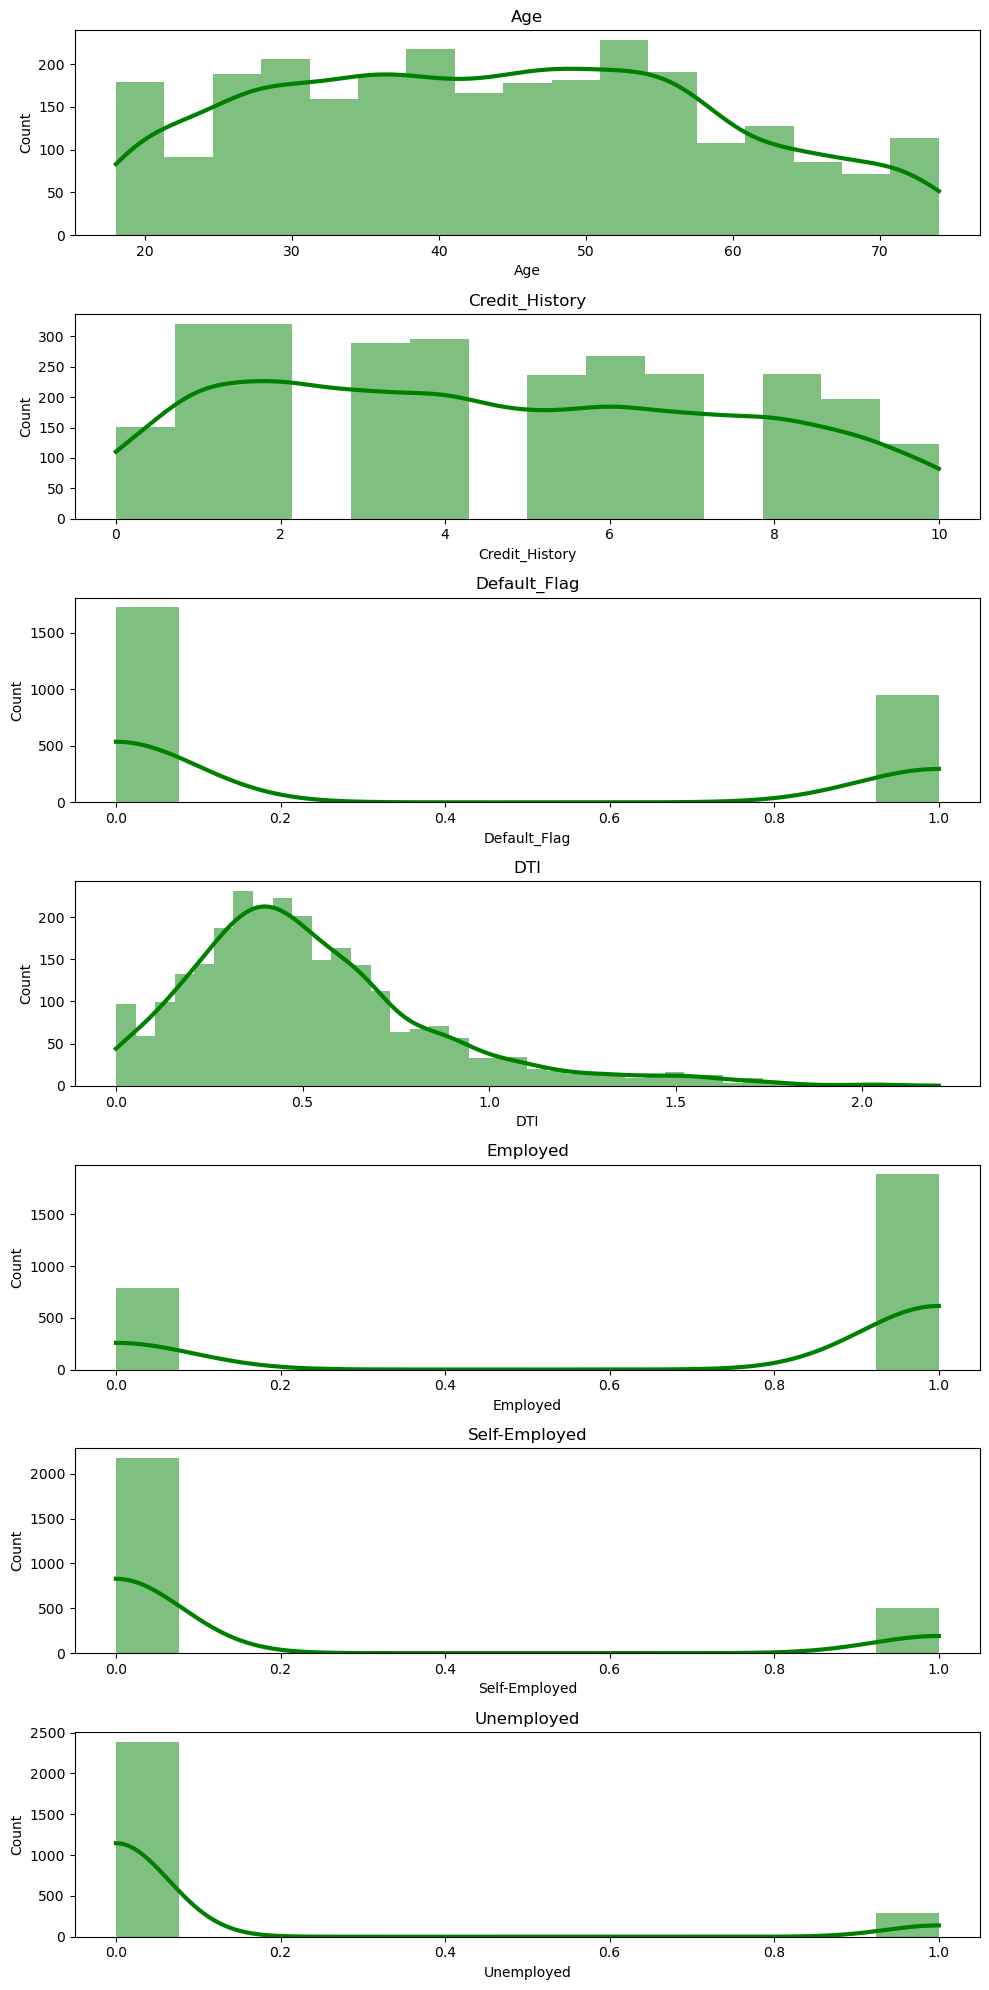

In [ ]:
# View the distribution of different values of the columns

plt.figure(figsize=(10,20))

for i in range(len(data.columns)):
  plt.subplot(len(data.columns), 1, i+1) # subplot takes 3 arguments, 1st: no. of rows, 2nd: no. of columns, 3rd: the index of the current plot
  sns.histplot(data[data.columns[i]], kde=True, color="g", line_kws={"color": "b", "lw": 3}, edgecolor=None)
  plt.title(data.columns[i])

plt.tight_layout()

### **(3) Modeling of Logistic Regression**
We split the dataset into training (70%) and test (30%) sets, where the independent variables include income, credit history, outstanding balance, and employment status, while the target variable is whether the loan was repaid. The features are scaled to a 0–1 range using StandardScaler to ensure consistent weighting across variables. A logistic regression model with class balancing (to handle any imbalance between repaid and defaulted loans) is then trained on the scaled training data.

In [ ]:
# Split the data into training and test set (70% - 30%)
X = data[['Age', 'DTI', 'Credit_History','Employed', 'Self-Employed', 'Unemployed']] #independent variables
y = data['Default_Flag'] #target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
# Create a StandardScaler instance and fit it on the training set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Training the model on the training set
model = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

### **(4) Model Testing & Evaluation**
First, we analyze the weighting of each feature when making the default/ repayment decision, which is determined by the coefficient in the logistic regression equation. A higher positive coefficient represents a higher probability of repayment, whereas a more negative coefficient suggests a higher probability of default. From the results, income and outstanding loan balance are the major positive and negative drivers, respectively.

Then, a confusion matrix is plotted to visualize prediction outcomes. The model achieves a recall of 0.84 for defaulters (class 0), meaning it successfully identifies most risky borrowers. It also records a strong PR-AUC score, reflecting its ability to balance precision and recall in the imbalanced dataset, and a very high ROC-AUC of 0.95, showing excellent overall discrimination between repayers and defaulters.

In [ ]:
# Coefficients for each feature
coefficients = model.coef_[0]

# Intercept (bias term)
intercept = round(model.intercept_[0], 3)

# Match coefficients with feature names
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": coefficients,
    "Odds_Ratio": np.exp(coefficients)  # convert to odds ratio
})

print("Intercept (bias):", intercept)
print(feature_importance)


Intercept (bias): -0.298
          Feature  Coefficient  Odds_Ratio
0             Age     0.294021    1.341813
1             DTI     2.498821   12.168138
2  Credit_History    -0.764752    0.465450
3        Employed    -0.247377    0.780846
4   Self-Employed     0.016554    1.016692
5      Unemployed     0.342603    1.408609


In [ ]:
# Forecast the ability of loan repayment using the logistic regression model
predictions = model.predict(X_test)

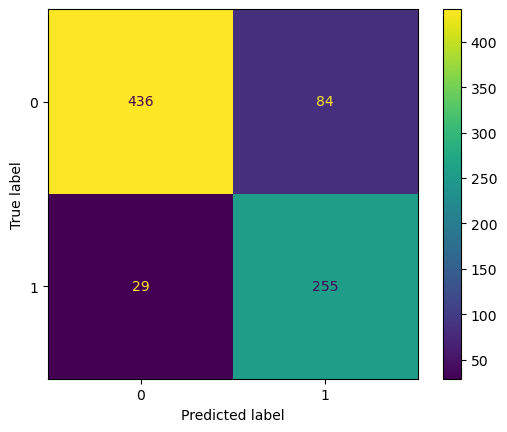

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.show()

In [ ]:
# Important Evaluation Metrics for the model
# High sensitivity (recall) for catching true defaulters
recall_default = recall_score(y_test, predictions)
print("Recall of the model: ", round(recall_default, 2))

# A high PR-AUC showing finding actual defaulters (Recall) well without too many false alarms (Precision)
y_prob = model.predict_proba(X_test)[:, 1]
ap = average_precision_score(y_test, y_prob)
print("PR-AUC (Precision-Recall Curves):", round(ap, 2))

# The model has outstanding performance in binary classification with very high ROC-AUC score
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print('ROC-AUC: ', round(roc_auc, 2))

Recall of the model:  0.9
PR-AUC (Precision-Recall Curves): 0.9
ROC-AUC:  0.95


In [ ]:
# A high F1 score shows it is a well-balanced model when handling false positives and false negatives
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89       520
           1       0.75      0.90      0.82       284

    accuracy                           0.86       804
   macro avg       0.84      0.87      0.85       804
weighted avg       0.87      0.86      0.86       804



### **(5) Save the Models/ Scaler/ Explainer**
The saved models, scaler and explainer alongside the dataset and other supporting files are uploaded to a public [Github repo](https://github.com/cckmwong-data/credit_scoring) which will be linked to and deployed in a Streamlit app.

In [ ]:
import shap

# Extract the column names as the feature names
feature_names = X.columns

# Create SHAP explainer with the feature names
explainer = shap.Explainer(model, X_train, feature_names=feature_names)

In [ ]:
import pickle
with open("credit_model.pkl", "wb") as f: pickle.dump(model, f) # save the model
with open("credit_scaler.pkl", "wb") as f: pickle.dump(scaler, f) # save the scaler
with open("credit_explainer.pkl", "wb") as f: pickle.dump(explainer, f) # save the SHAP explainer

## **Conclusion**

This Loan Approval Prediction model successfully demonstrates an interpretable and data-driven approach to assessing loan repayment likelihood. By employing logistic regression, the project identifies the most influential financial and demographic factors affecting repayment outcomes, supported by feature importance and SHAP explainability analyses. Evaluation metrics such as accuracy, precision, recall, F1-score, and AUC values indicate that the model performs reliably in distinguishing between applicants likely and unlikely to repay their loans. While the model offers transparency and solid baseline performance, further improvements such as hyperparameter tuning, cross-validation, and testing alternative algorithms like Random Forest or XGBoost could enhance accuracy and robustness.